In [ ]:
# VaR for a portfolio of FNZ.NZ (nzx top 50) and VOO (vanguard s&p 500)
# take into account exchange rate for VOO investment

In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns   #seaborn is a nice skin for matplotlib
sns.set()
from tabulate import tabulate
from IPython.display import display

# Import Data

In [3]:
# define symbols
tickers = ['FNZ.NZ', 'VOO', 'NZDUSD=X']

# define data range to extract data from
start_date = datetime.today() - timedelta(days = 365*10)    # roughly 10 years ago. Not exact same date, but good enough. Need extra dates to fillna values anyway
end_date = datetime.today()
display(start_date, end_date)

datetime.datetime(2012, 10, 21, 15, 31, 27, 588190)

datetime.datetime(2022, 10, 19, 15, 31, 27, 588190)

In [33]:
# get data from pandas_datareader. Source = yahoo finance
data = pdr.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
data.head()

Attributes Adj Close                        Close                        \
Symbols       FNZ.NZ         VOO  NZDUSD=X FNZ.NZ         VOO  NZDUSD=X   
Date                                                                      
2012-10-21       NaN         NaN  0.815727    NaN         NaN  0.815727   
2012-10-22     1.445  109.065987  0.818331  1.445  131.320007  0.818331   
2012-10-23     1.440  107.471352  0.811227  1.440  129.399994  0.811227   
2012-10-24     1.440  107.238785  0.820681  1.440  129.119995  0.820681   
2012-10-25     1.440  107.537796  0.819941  1.440  129.479996  0.819941   

Attributes   High                          Low                         Open  \
Symbols    FNZ.NZ         VOO  NZDUSD=X FNZ.NZ         VOO  NZDUSD=X FNZ.NZ   
Date                                                                          
2012-10-21    NaN         NaN  0.819202    NaN         NaN  0.815727    NaN   
2012-10-22  1.445  131.500000  0.818398  1.442  130.259995  0.810373  1.444   
2012-10-23  1.444  130.039993  0.816527  1.437  128.960007  0.811162  1.440   
2012-10-24  1.443  130.100006  0.824470  1.430  128.919998  0.820143  1.440   
2012-10-25  1.440  130.240005  0.823927  1.437  128.720001  0.817194  1.437   

Attributes                          Volume                     
Symbols            VOO  NZDUSD=X    FNZ.NZ       VOO NZDUSD=X  
Date                                                           
2012-10-21         NaN  0.815727       NaN       NaN      0.0  
2012-10-22  131.080002  0.818398  167581.0  503500.0      0.0  
2012-10-23  129.919998  0.811162  101293.0  519000.0      0.0  
2012-10-24  129.899994  0.821085   82272.0  365650.0      0.0  
2012-10-25  130.080002  0.819605   34422.0  485500.0      0.0

In [34]:
# take adjusted close only
display(data['Adj Close'].head())
display(data['Adj Close'].tail())

Symbols,FNZ.NZ,VOO,NZDUSD=X
Date,,,
2012-10-21,NaN,NaN,0.815727
2012-10-22,1.445,109.065987,0.818331
2012-10-23,1.440,107.471352,0.811227
2012-10-24,1.440,107.238785,0.820681
2012-10-25,1.440,107.537796,0.819941


Symbols,FNZ.NZ,VOO,NZDUSD=X
Date,,,
2022-10-13,2.932,336.220001,0.563911
2022-10-14,NaN,328.649994,NaN
2022-10-16,2.905,NaN,0.557600
2022-10-17,NaN,337.000000,0.565668
2022-10-18,2.918,340.970001,0.569022


In [35]:
# fillna with value of the previous day
ClosePrice = data['Adj Close'].fillna(method="ffill")
display(ClosePrice.head())
display(ClosePrice.tail())

Symbols,FNZ.NZ,VOO,NZDUSD=X
Date,,,
2012-10-21,NaN,NaN,0.815727
2012-10-22,1.445,109.065987,0.818331
2012-10-23,1.440,107.471352,0.811227
2012-10-24,1.440,107.238785,0.820681
2012-10-25,1.440,107.537796,0.819941


Symbols,FNZ.NZ,VOO,NZDUSD=X
Date,,,
2022-10-13,2.932,336.220001,0.563911
2022-10-14,2.932,328.649994,0.563911
2022-10-16,2.905,328.649994,0.557600
2022-10-17,2.905,337.000000,0.565668
2022-10-18,2.918,340.970001,0.569022


In [36]:
# use only from the 2nd row because the 1st row values are null
ClosePrice = ClosePrice[1:]
# export to csv. Shall only with this exported data because it shall be static
ClosePrice.to_csv('AdjClosePrice.csv')

In [4]:
df = pd.read_csv('AdjClosePrice.csv', header=0)
df.head()

,Date,FNZ.NZ,VOO,NZDUSD=X
0,2012-10-22,1.445,109.065987,0.818331
1,2012-10-23,1.440,107.471352,0.811227
2,2012-10-24,1.440,107.238785,0.820681
3,2012-10-25,1.440,107.537796,0.819941
4,2012-10-26,1.440,107.454735,0.819941


In [5]:
print('count null value for each column:')
df.isnull().sum()

count null value for each column:


Date        0
FNZ.NZ      0
VOO         0
NZDUSD=X    0
dtype: int64

# Returns & Values

## compute

In [6]:
# assume initial investment of NZD1000 in each ticker. 
invst = 1000

# assume the portfolio consists of equal weight investment in each ticker
weightInvt = 1/2

In [7]:
# compute return. Use Log return instead because dealing with 10 years data here
df_returns = df[tickers].pct_change()   # (OPTIONAL) = arithmetic return = end/begin - 1 
df_returns = np.log(df[tickers]) - np.log(df[tickers].shift(1))     # = geometric return = log(end/begin) = log(end) - log(begin)
df_returns['VOOnzd'] = df_returns['VOO'] - df_returns['NZDUSD=X']   # return of VOO converted to NZD
df_returns['Portf_return'] = (df_returns['FNZ.NZ']*weightInvt + df_returns['VOOnzd']*(1-weightInvt))   # return of the portfolio in NZD
df_returns.index = df['Date'].values
df_returns = df_returns[1:]     # only take the second row because return value will always be missing for the first row

# compute value of investment if invest the initial amount in each stock/portfolio individually
df_values = pd.DataFrame(index=df_returns.index)
df_values['FNZ.NZnzd_value'] = invst * np.exp(df_returns['FNZ.NZ'].cumsum())
df_values['VOOnzd_value'] = invst * np.exp(df_returns['VOOnzd'].cumsum())
df_values['Portfnzd_value'] = invst * np.exp(df_returns['Portf_return'].cumsum())

print('returns:')
display(df_returns.head())
display(df_returns.tail())
print('values:')
display(df_values.head())
display(df_values.tail())

returns:


,FNZ.NZ,VOO,NZDUSD=X,VOOnzd,Portf_return
2012-10-23,-0.003466,-0.014729,-0.008718,-0.006011,-0.004738
2012-10-24,0.000000,-0.002166,0.011586,-0.013753,-0.006876
2012-10-25,0.000000,0.002784,-0.000902,0.003687,0.001843
2012-10-26,0.000000,-0.000773,0.000000,-0.000773,-0.000386
2012-10-28,-0.002086,0.000000,0.000000,0.000000,-0.001043


,FNZ.NZ,VOO,NZDUSD=X,VOOnzd,Portf_return
2022-10-13,0.001707,0.025850,0.004928,0.020923,0.011315
2022-10-14,0.000000,-0.022772,0.000000,-0.022772,-0.011386
2022-10-16,-0.009251,0.000000,-0.011254,0.011254,0.001001
2022-10-17,0.000000,0.025090,0.014366,0.010723,0.005362
2022-10-18,0.004465,0.011712,0.005912,0.005800,0.005132


values:


,FNZ.NZnzd_value,VOOnzd_value,Portfnzd_value
2012-10-23,996.539796,994.007271,995.272728
2012-10-24,996.539796,980.430638,988.452400
2012-10-25,996.539796,984.051863,990.276144
2012-10-26,996.539796,983.291790,989.893630
2012-10-28,994.463657,983.291790,988.861946


,FNZ.NZnzd_value,VOOnzd_value,Portfnzd_value
2022-10-13,2029.065616,4473.552641,3012.827882
2022-10-14,2029.065616,4372.830417,2978.717819
2022-10-16,2010.380530,4422.320882,2981.702165
2022-10-17,2010.380530,4469.998577,2997.732161
2022-10-18,2019.377077,4495.999418,3013.157507


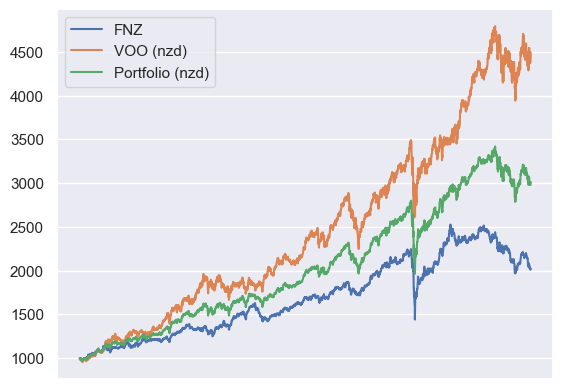

In [8]:
# plot cumulative value
ax = plt.gca()
ax.get_xaxis().set_visible(False)
FNZnzd = plt.plot(df_values.index, df_values['FNZ.NZnzd_value'], label='FNZ')
VOOnzd = plt.plot(df_values.index, df_values['VOOnzd_value'], label='VOO (nzd)')
Portfnzd = plt.plot(df_values.index, df_values['Portfnzd_value'], label='Portfolio (nzd)')
plt.legend(loc='upper left')
plt.show()

## returns covariance & correlation

In [9]:
# covariance matrix between 2 tickers and NZDUSD only 
df_returns.cov()

,FNZ.NZ,VOO,NZDUSD=X,VOOnzd,Portf_return
FNZ.NZ,0.000049,0.000021,0.000003,0.000018,0.000034
VOO,0.000021,0.000098,0.000010,0.000088,0.000054
NZDUSD=X,0.000003,0.000010,0.000035,-0.000025,-0.000011
VOOnzd,0.000018,0.000088,-0.000025,0.000113,0.000065
Portf_return,0.000034,0.000054,-0.000011,0.000065,0.000049


,FNZ.NZ,VOO,NZDUSD=X,VOOnzd,Portf_return
FNZ.NZ,1.000000,0.301496,0.078859,0.236329,0.678166
VOO,0.301496,1.000000,0.170496,0.834744,0.781919
NZDUSD=X,0.078859,0.170496,1.000000,-0.400256,-0.263343
VOOnzd,0.236329,0.834744,-0.400256,1.000000,0.874362
Portf_return,0.678166,0.781919,-0.263343,0.874362,1.000000


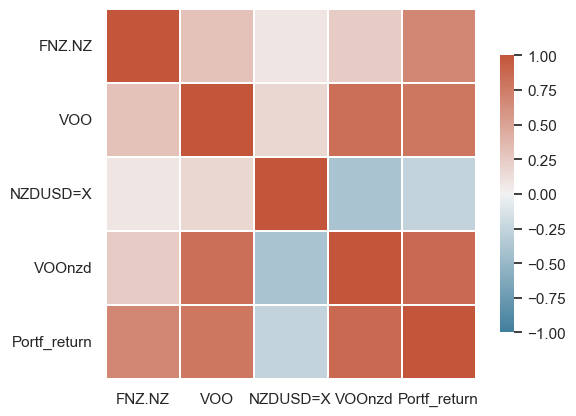

In [10]:
# correlation matrix and its heat map
display(df_returns.corr())  # value

sns.heatmap(
    data=df_returns.corr(),  
    linewidths=0.3,  # the width of lines separating the matrix squares
    square=True,   # enforce 1:1 ratios among correlation cells
    cmap=sns.diverging_palette(230, 20, as_cmap=True),  # use custom color map 
    vmax=1,  # define the max of correlation scale
    vmin=-1, # define the min of correlation scale
    center=0,  # The value at which the color map is centered about (white)
    cbar_kws={"shrink": .75}  # shrink the scale a bit
)
plt.yticks(rotation=0)  # rotate y-axis label for readability
plt.show()

# Portfolio

## Mean and Standard Deviation

In [24]:
portf_mean = df_returns['Portf_return'].mean()  # Or = df_returns[['FNZ.NZ','VOOnzd']].mean().dot([0.5,0.5])
portf_stdv = df_returns['Portf_return'].std()

print('Portfolio mean returns = ',portf_mean)
print('Portfolio s.d. returns = ',portf_stdv)

Portfolio mean returns =  0.00035603245148561706
Portfolio s.d. returns =  0.007032740006535515


$$Porfolio\ Standard\ Deviation = \sqrt{weights^T . (covariance\ matrix) . weights}$$

## Compare returns against Normal Distribution

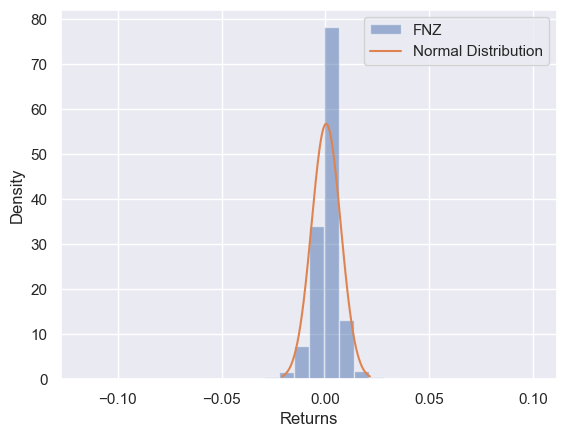

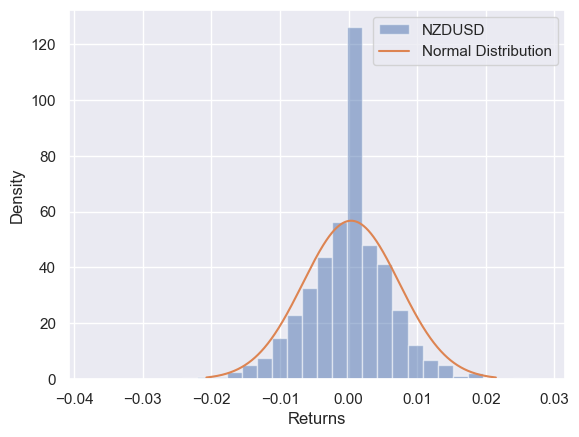

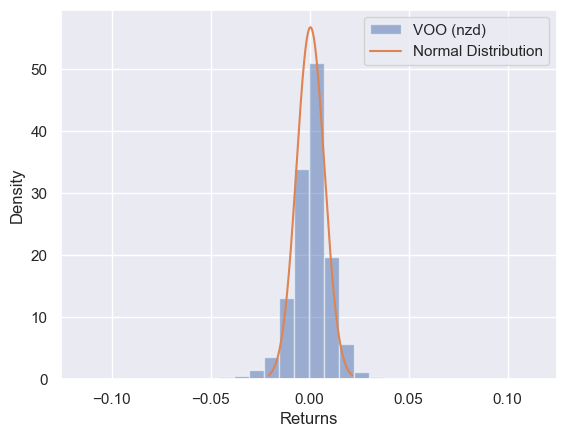

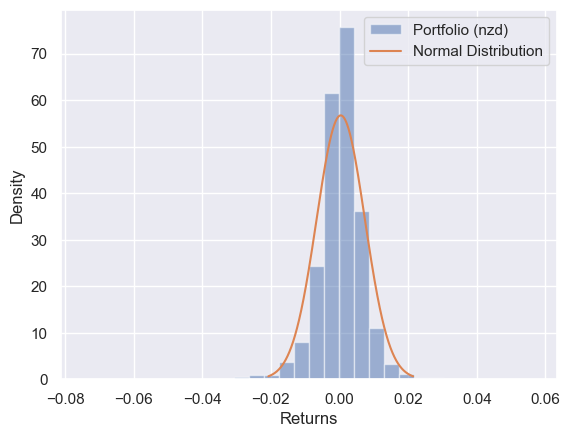

In [27]:
# plot 3 returns against Normal Distribution
Xaxis = np.linspace(portf_mean -3 * portf_stdv, portf_mean +3 * portf_stdv, 1000)   # 1000 evenly spaced numbers between +/- 3 times portfolio's standard deviation
plt.hist(df_returns['FNZ.NZ'], alpha=0.5, bins=30, density=True, label='FNZ')       # returns as histogram 
plt.plot(Xaxis, norm.pdf(Xaxis,portf_mean,portf_stdv), label='Normal Distribution')    # Normal Distribution as line. Using portfolio's mean & s.d.
plt.legend()
plt.xlabel('Returns')
plt.ylabel('Density')
plt.show()

plt.hist(df_returns['VOOnzd'], alpha=0.5, bins=30, density=True, label='VOO (nzd)')       # returns as histogram 
plt.plot(Xaxis, norm.pdf(Xaxis,portf_mean,portf_stdv), label='Normal Distribution')    # Normal Distribution as line. Using portfolio's mean & s.d.
plt.legend()
plt.xlabel('Returns')
plt.ylabel('Density')
plt.show()

plt.hist(df_returns['NZDUSD=X'], alpha=0.5, bins=30, density=True, label='NZDUSD')     # returns as histogram 
plt.plot(Xaxis, norm.pdf(Xaxis,portf_mean,portf_stdv), label='Normal Distribution')    # Normal Distribution as line. Using portfolio's mean & s.d.
plt.legend()
plt.xlabel('Returns')
plt.ylabel('Density')
plt.show()

plt.hist(df_returns['Portf_return'], alpha=0.5, bins=30, density=True, label='Portfolio (nzd)')       # returns as histogram 
plt.plot(Xaxis, norm.pdf(Xaxis,portf_mean,portf_stdv), label='Normal Distribution')    # Normal Distribution as line. Using portfolio's mean & s.d.
plt.legend()
plt.xlabel('Returns')
plt.ylabel('Density')
plt.show()

# VaR

$$VaR\ = -(mean\ - standard\ deviation * Z_a * \sqrt{days}) $$

In [37]:
# VaR = [returns' mean - (critical value of the standard normal distribution @ alpha confidence level) * returns' s.d.] * [portfolio $ value]
# VAR = [mu - ppf@confidence levl * stdev] * [portfolio $ value]
# (OPTIONAL) can take the negative value of the above to represent VaR as negative number, as a loss value
# VaR over n-day = VaR 1-day multiply by sqrt(days)
def calc_VaR(alpha, mu, std, portfolio_value, num_days):
    '''
        alpha = confidence level
        mu = mean
        std = portfolio change standard deviation
        portfolio = portfolio value
        num_days = nth day
    '''
    return abs((mu - norm.ppf(alpha) * std * np.sqrt(num_days)) * portfolio_value)

In [50]:
# define the confidence level
conf_levels = [0.10, 0.05, 0.01]

# compute parametric VaR for given confidence levels, @ 1-day interval
parametric_VaRs = [calc_VaR(conf_level, portf_mean, portf_stdv, invst, 1) for conf_level in conf_levels]

# print results
for i, VaR in enumerate(parametric_VaRs):
    print('VaR @ {0}%'.format((1-conf_levels[i])*100),'=', round(VaR,2))

VaR @ 90.0% = 9.37
VaR @ 95.0% = 11.92
VaR @ 99.0% = 16.72


# Conditional VaR = CVaR = Expected Shortfall = ES

In [51]:
# CVaR = probability-weighted average of tail losses
# CVaR = dividing the α tail by equal number of slices. Then estimating VaR for each slice. Then taking average of those VaR
def calc_CVaR(alpha, mu, std, portfolio_value, num_days):
    return (mu + alpha**-1 * norm.pdf(norm.ppf(alpha))* std * np.sqrt(num_days))*portfolio_value

In [53]:
# compute parametric CVaR for given confidence levels, @ 1-day interval
parametric_CVaRs = [calc_CVaR(conf_level, portf_mean, portf_stdv, invst, 1) for conf_level in conf_levels]

# print results
for i, CVaR in enumerate(parametric_CVaRs):
    print('CVaR @ {0}%'.format((1-conf_levels[i])*100),'=', round(CVaR,2))

CVaR @ 90.0% = 12.7
CVaR @ 95.0% = 14.86
CVaR @ 99.0% = 19.1


In [13]:
df_returns.head()

,FNZ.NZ,VOO,NZDUSD=X,VOOnzd,Portf_return
2012-10-23,-0.003466,-0.014729,-0.008718,-0.006011,-0.004738
2012-10-24,0.000000,-0.002166,0.011586,-0.013753,-0.006876
2012-10-25,0.000000,0.002784,-0.000902,0.003687,0.001843
2012-10-26,0.000000,-0.000773,0.000000,-0.000773,-0.000386
2012-10-28,-0.002086,0.000000,0.000000,0.000000,-0.001043
